<a href="https://colab.research.google.com/github/AriannaGrossi/MLPNS_AGrossi/blob/main/EthicsAIaenc_faces_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook
(Altro notebook sul variational autoencoder)

create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

Invece di fare digits, invece di fare cifre scritte a mano, utilizziamo il notebook con immagini di persone, e il goal sarà di aumentare la risoluzione della immagine

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Dense #, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [3]:
import glob
import h5py #importo h5py, vi consiglio in questo notebook di salvare diverse cose: salvare le immagini
#in un numpy array dopo averle lette e processate, così non dobbiamo fare l'input/output, perchè è molto time
#consuming, perchè ci sono molte immagini, e poi salvate anche modelli, così che se vogliamo lavorare su predizione
#ma abbiamo già trainato abbiamo il modello salvato. Per salvare i modelli uso h5py, che è un formato di file
#binari ed è il tipico formato in cui si salvano modelli di NN
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [4]:
cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip

#Per scaricare le immagini ci ha dato un link su slack: se vogliamo possiamo riscaricare tutti i dati e
#ricaricarli sul nostro google drive, ma più semplicemente se andiamo al link possiamo usare add shortcut
#to drive---> MyDrive, che mette il link su nostro drive, e lo possiamo mettere su MLPNS2023.
#Se lo aggiungiamo su MLPNS2023 abbiamo la struttura sintattica che utilizza lei andando poi a cercare
#le immagini sulla directory MLPNS2023, altrimenti se lo mettiamo da un altra parte dobbiamo cambiare
#la sintassi del comando


In [5]:
!ls MLPNS2023

faces95        logs	  spm				wine.data
kaggleTitanic  model.png  spm-20210427T111354Z-001.zip	wine.names


In [ ]:
#!unzip faces95.zip

In [6]:
flist = glob.glob("MLPNS2023/faces95/*/*jpg")
#Dopo aver messo il file su drive, ottengo le immagini dal file con questa sintassi: prima
#colleziono la lista delle immagini e poi una per una devo uploadare le immagini (vai alla cella sotto...)

In [7]:
N = len(flist)
N

1441


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

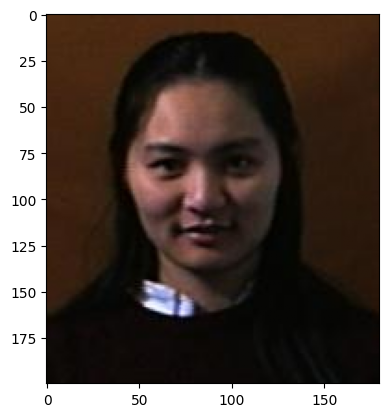

In [8]:
#Una ad una devo uploadare le immagini e lo faccio con il pacchetto PIL, e la funzione Image.open:
#le immagini sono ritratti di studenti di un professore che ha sviluppato questo NN
#Siccome quello che voglio fare è creare un modello che migliori la risoluzione delle immagini,
#devo creare un target che è una immagine superisolta. Obv non lo posso fare, e voglio creare un NN per farlo
#perchè se lo sapessi fare non dovrei creare un NN, perciò invece di manipolare l'output manipolo
#l'input, cioè riduco la dimensionalità delle immagini in input per poi dargli come target la dimensionalità
#corretta. In realtà dal momento che ho memoria limitata sulla versione gratis di colab, ho dovuto
#ridurre la dimensionalità delle immagini che erano già in input, quindi lavoreremo su low resolution images
#di questo tipo (immagine sotto), e ancora più low resolution come input dati
im = Image.open(flist[40])

np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

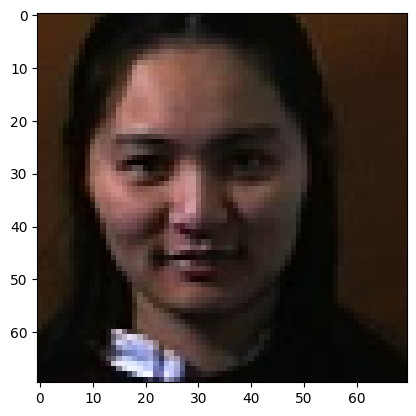

In [9]:
pl.imshow(np_im[25:165:2,25:165:2])

#Ho anche tagliato le immagini così che alla fine c'è solo la faccia e non mi devo preoccupare
#del background, e l'ho fatto automaticamente per tutte le immagini (codice cella sotto)

<font color='red'>you can skip this and go  straight to loading the images</font>

In [13]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255
  # here I collect the certain portion of each image
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-13-f56f85703461>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1441 [00:00<?, ?it/s]

In [14]:
np.save("faces_saved.npy", imgs)
#salvo le immagini come un numpy array

# 1B you can read the images below if you have saved them earlier

In [15]:
#se voglio chiudere il notebook e ritornarci
#dopo salto tutta la prima parte e comincio, dopo essere andata sul mio colab folder, uploadando
#le immagini che ho già salvato, tagliato e messo in bianco e nero (per cui utilizzo uno solo dei 3 layer)

#Queste sono le mie immagini in input
imgs = np.load("faces_saved.npy")
imgs.shape

(1441, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command
          train_test_split(input, target, test_size = .25, random_state=1)
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [16]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [17]:
#lower the resolution: cambio ora la risoluzione delle mie immagini

#imgs_lr = imgs[:,::2,::2] : si può fare con questa sintassi, scelgo tutte le immagini dal primo pixel
#all'ultimo pixel saltando un pixel si un pixel no (il terzo 2 vuol dire che prendo un pixel si un pixel no,
#e si chiama la stride)

#slightly better than the line of code above: ho anche una sintassi più sofisticata per farlo, ma sono la
#stessa cosa
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2,
                        int(imgs.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1441, 35, 35)

In [18]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape),

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [19]:
#Divido tra training e testing e target e input, in questo caso che sono diversi

from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig,
                                             test_size = .20, random_state=1)


In [20]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 35, 35), (289, 35, 35), (1152, 70, 70, 1), (289, 70, 70, 1))

In [22]:
#each image needs to be unravel into a flat array: qui ho srotolato le immagini di nuovo, quindi
#le ho usate in fila, come tutti i pixel in fila, quindi ho perso la struttura bidimensionale
#della immagine, per poter creare un autoencoder come quello che ho fatto prima, quindi dense
#layers ? (quello delle cifre scritte a mano) (vai alla cella sotto...)
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))


In [23]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 1225), (289, 1225), (1152, 4900), (289, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [24]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1225))
model.add(Dense(128, activation='relu', name="bottleneck"))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(1225*4, activation='sigmoid'))
model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


ESERCIZIO: quello che dobbiamo fare noi è non srotolare le immagini cambiando la shape, ma sostituire i dense layer nel modello sotto con convolutional layers... Se voglio sostituirli con convolutional layer il modo in cui diminuisco la dimensionalità del layer non è più il numero dei neuroni, ma ho sia la dimensione dei neuroni, ma voglio anche diminuire la dimensione della immagine: quindi ho un convolutional layer di 512 neuroni, un convolutional layer di 256, un convolutional layer di 128. Li ho messi tutti 3x3, quindi la dimensione del kernel sono 9 pixels.
Ho introdotto i maxpool layers, ma siccome ho introdotto il maxpool layer devo introdurre la operazione inversa, quindi ho il maxpool layer nell'encoder, devo introdurre una operazione inversa nel decoder. Per cui qui ho convolution alternata con maxpool, qui ho convolution alternata con upsampling2d (inverso del maxpool), fino ad ottenere un convolutional layer alla fine del decoder che produce la decoded image.

Creo l'encoder, creo il decoder e poi li passo alla funzione modello ecc

Quindi qui lo facciamo con dense, noi lo dobbiamo fare con il convolutional e dire se migliora

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6702001 (25.57 MB)
Trainable params: 6702001 (25.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [26]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [27]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000,
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
#model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
72/72 [==============================] - 7s 12ms/step - loss: 0.0391 - mae: 0.1549 - acc: 0.0026 - val_loss: 0.0330 - val_mae: 0.1385 - val_acc: 0.0000e+00
Epoch 2/100000
72/72 [==============================] - 0s 6ms/step - loss: 0.0262 - mae: 0.1242 - acc: 8.6806e-04 - val_loss: 0.0230 - val_mae: 0.1184 - val_acc: 0.0000e+00
Epoch 3/100000
72/72 [==============================] - 0s 5ms/step - loss: 0.0199 - mae: 0.1066 - acc: 0.0035 - val_loss: 0.0191 - val_mae: 0.1041 - val_acc: 0.0035
Epoch 4/100000
72/72 [==============================] - 0s 5ms/step - loss: 0.0178 - mae: 0.0999 - acc: 8.6806e-04 - val_loss: 0.0172 - val_mae: 0.0979 - val_acc: 0.0000e+00
Epoch 5/100000
72/72 [==============================] - 0s 5ms/step - loss: 0.0157 - mae: 0.0928 - acc: 0.0035 - val_loss: 0.0158 - val_mae: 0.0931 - val_acc: 0.0069
Epoch 6/100000
72/72 [==============================] - 0s 5ms/step - loss: 0.0139 - mae: 0.0865 - acc: 0.0017 - val_loss: 0.0139 - val_mae: 0.0853 -

In [ ]:
#model.save("data/imgreconstruct_10000.h5")

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/imgreconstruct_10000.h5")

## predict

Ora voglio predire una immagine superisolta

In [28]:
outim = model.predict(X_te)
outim

10/10 [==============================] - 0s 2ms/step


array([[0.21871349, 0.21980627, 0.1981662 , ..., 0.05516832, 0.07083479,
        0.07271195],
       [0.48450056, 0.47380996, 0.46996397, ..., 0.13884729, 0.16871113,
        0.19151399],
       [0.2260272 , 0.22843674, 0.21523122, ..., 0.04434642, 0.04724316,
        0.05134995],
       ...,
       [0.26571983, 0.26653764, 0.26679987, ..., 0.22791825, 0.24082486,
        0.26769838],
       [0.24301142, 0.25356752, 0.24590121, ..., 0.1534298 , 0.1594227 ,
        0.15484616],
       [0.4055207 , 0.41604206, 0.40895116, ..., 0.10838176, 0.11521014,
        0.12553328]], dtype=float32)

In [29]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131)
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133)
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


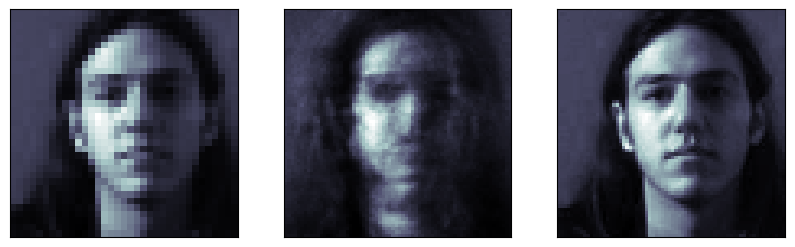

2 :	input		      prediction		  target


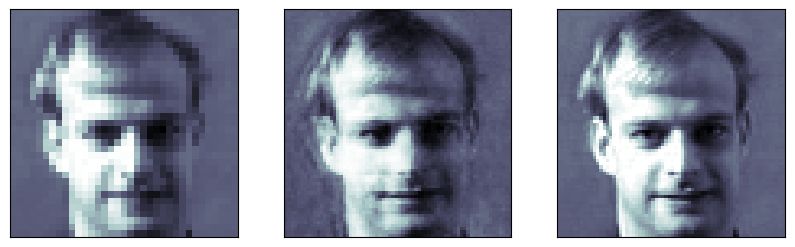

3 :	input		      prediction		  target


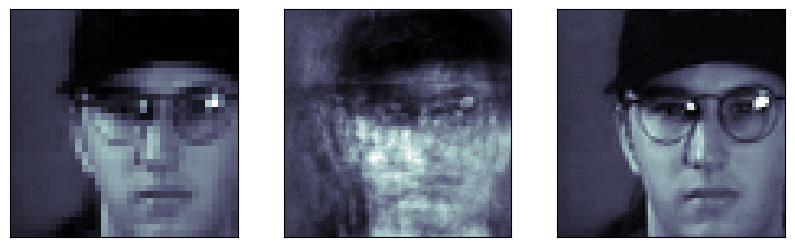

4 :	input		      prediction		  target


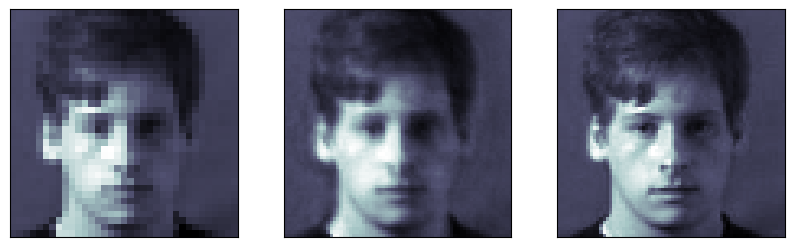

5 :	input		      prediction		  target


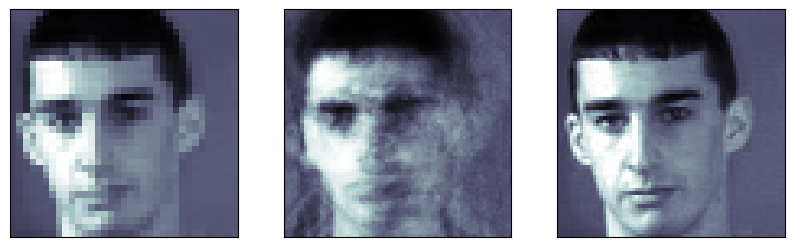

6 :	input		      prediction		  target


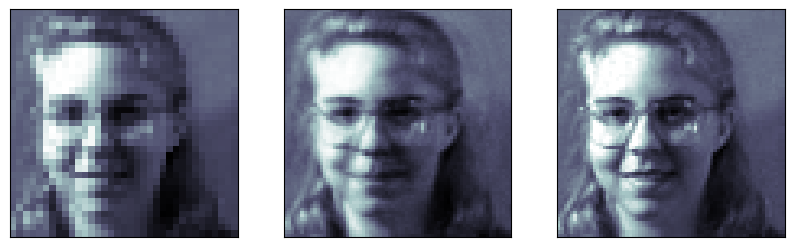

7 :	input		      prediction		  target


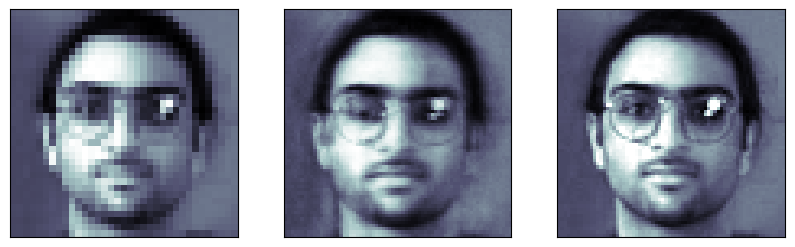

8 :	input		      prediction		  target


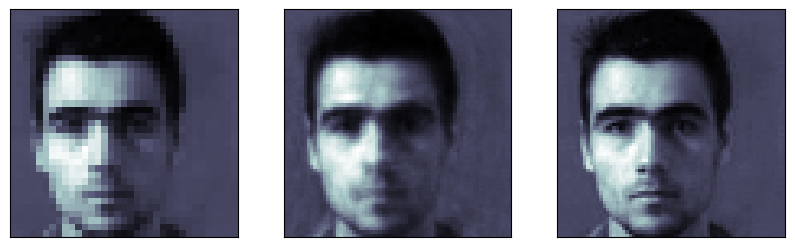

9 :	input		      prediction		  target


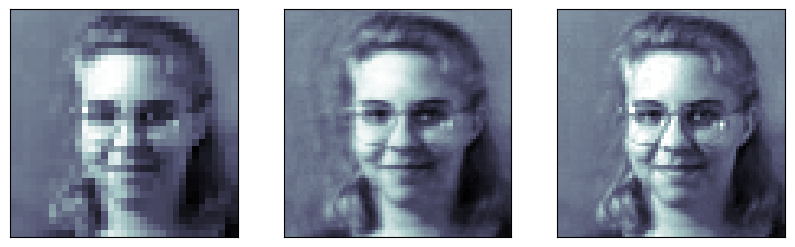

10 :	input		      prediction		  target


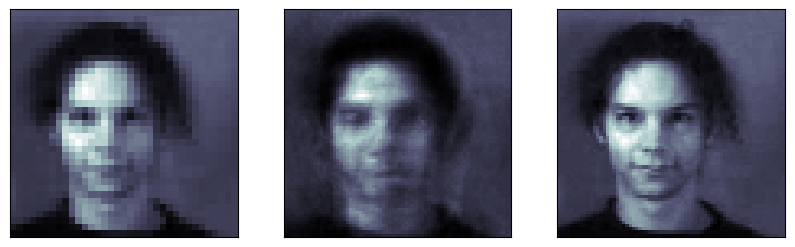

In [30]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

#All'inizio ho l'input, alla fine il target e in mezzo la predizione. Guardiamo
#le predizioni di questo random set di immagini individuali e vediamo la qualità:
#alcune vanno abbastanza bene, posso migliorare il NN e ottenere miglioramenti, ma sono
#sono partita da qua e sicuramente ho migliorato la risoluzione dell'immagine in maniera coerente
#In alcuni casi invece no... Quale potrebbe essere il problema? Perchè alcune
#vanno bene ed altre no? Perchè alcune predizioni sono migliori di altre? E ciò è un problema che è vero per tutta la AI generativa...Le immagini sono
#immagini di studenti di computer science all'MIT negli anni 2000, quando questo modello
#è stato creato e pubblicato e il dataset associato è stato creato e pubblicato, sono tutti
#gli studenti del professore. Cosa hanno in comune gli studenti di computer science all'MIT
#nei primi anni 2000? Questo dataset è dominato da studenti maschi e bianchi, ed è stato dimostrato
#che la predizione su studenti femmine o studenti di diversa etnia è molto peggiore
#di quella degli studenti che sono tipici. Il problema matematico, di computer science,
#è che i network sono bravi a interpolare, ma non a estrapolare, per cui se i dati sono
#caratteristici del dataset la predizione può essere ottima, ma se ci sono deviazioni
#la predizione diventa meno ottima.
#C'è un altro caso, il ritratto di uno studente che è off centered, e il NN non sa cosa fare perchè non ha imparato come
#risolvere il problema degli off centered, perchè non gli sono stati dati esempi di off centered images,
#e questo è un problema comune a tutta la generative AI

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## show the latent representation of the data: the bottleneck layer output

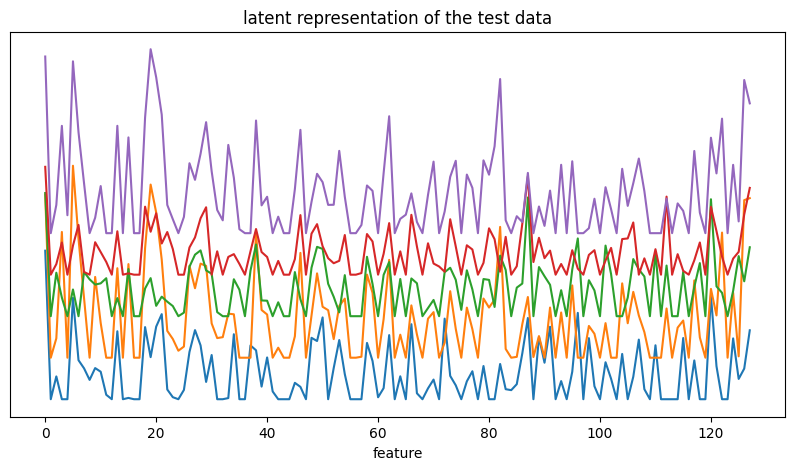

In [31]:
from keras import backend as K
# input placeholder
inp = model.input
# extract the bottle neck outputs
outputs = model.layers[1].output
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])

# Testing
layer_outs = functors(X_te[:5])

for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [40]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving Foto personale.jpg to Foto personale (1).jpg


In [41]:
file_contents = uploaded[list(uploaded.keys())[0]]


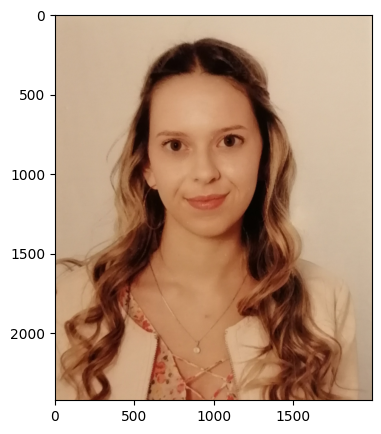

In [42]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

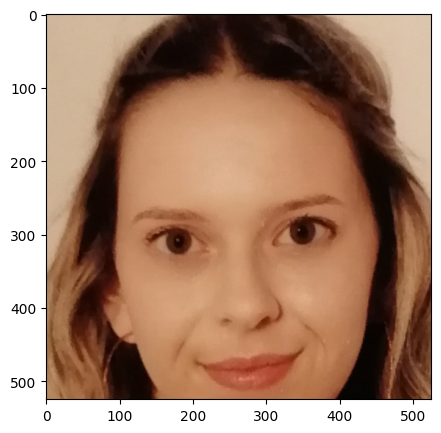

In [67]:

np_im = numpy.array(imme)[::2,::2,:3].astype(float) /255
pl.figure()
pl.imshow(np_im[100:625,200:725,:] )
np_im[100:625,200:725,:].shape, np.prod(np_im.shape[1:]);


low resolution version
subsampling by 15

In [68]:
np_im_me = np_im[100:625,200:725,:][::15,::15,1]
np_im_me.shape

(35, 35)

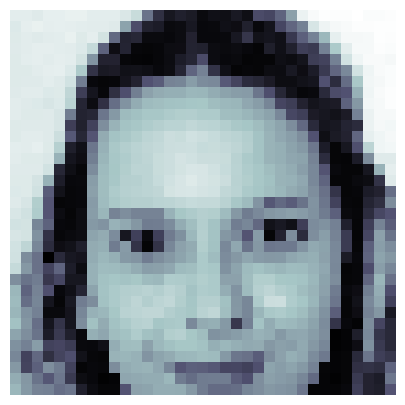

In [69]:

pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 [==============================] - 0s 20ms/step


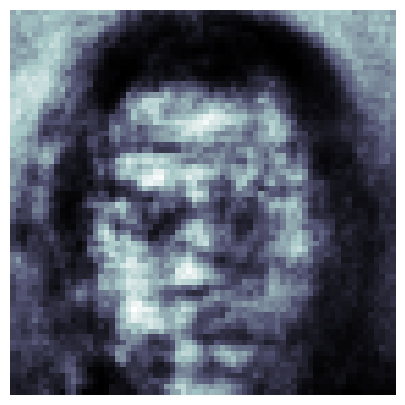

In [70]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70),
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??